In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [11]:
scale = 10

In [12]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

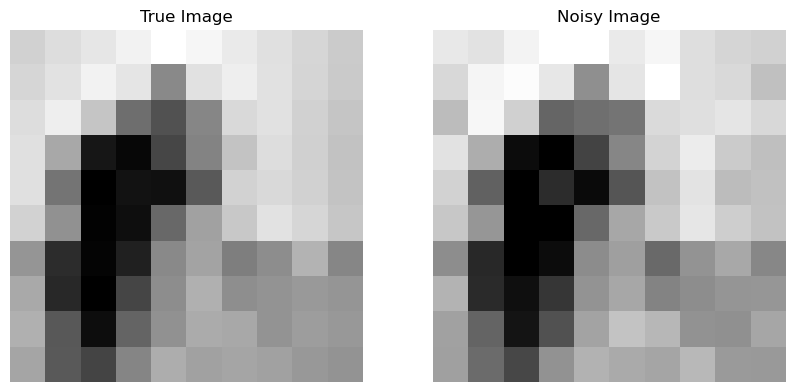

In [13]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [14]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [15]:
res,x_opt,fun_opt = model.solve(max_iter=10,tol=1e-2,print_level=5)

(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)


b'Invalid number of indices returned from jacobian'


In [9]:
print(len(x_opt))

41


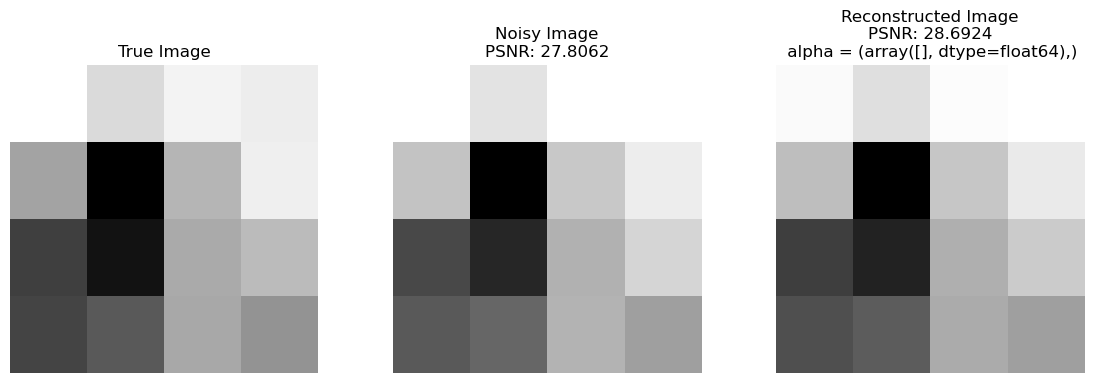

In [ ]:
# N = scale**2
# M = 2*N*(N-1)
# u = x_opt[:N]
# q = x_opt[N : N+M]
# alpha = x_opt[N+M:],
# u = u.reshape((scale,scale))
# plot_experiment(true,noisy,u,alpha)